# Modelo RNN  
Este es el primer modelo de red neuronal implementado. Con el se busca establecer las bases de arquitecturas a implementar en modelos mas complejos que involucren las redes neuronales.

In [ ]:
#!pip install tensorflow
#!pip install theano
#!pip install keras

In [3]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
from pathlib import Path # includes glob
#import glob             # Unix pathname pattern expansion, Ex. glob.glob('**/*.txt', recursive=True)
import pickle
warnings.filterwarnings("ignore")
# import altair as alt
import os
import seaborn
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model

## Lectura de datos

In [4]:
new_directory = os.getcwd()

In [5]:
data_casa_1 = pd.read_csv(new_directory + "\\low_freq\\data_casas\\data_casa_1.csv",sep=r' ',encoding='utf-8',header=0, index_col = 0)
data_casa_2 = pd.read_csv(new_directory + "\\low_freq\\data_casas\\data_casa_2.csv",sep=r' ',encoding='utf-8',header=0, index_col = 0)
data_casa_3 = pd.read_csv(new_directory + "\\low_freq\\data_casas\\data_casa_3.csv",sep=r' ',encoding='utf-8',header=0, index_col = 0)
data_casa_4 = pd.read_csv(new_directory + "\\low_freq\\data_casas\\data_casa_4.csv",sep=r' ',encoding='utf-8',header=0, index_col = 0)
data_casa_5 = pd.read_csv(new_directory + "\\low_freq\\data_casas\\data_casa_5.csv",sep=r' ',encoding='utf-8',header=0, index_col = 0)
data_casa_6 = pd.read_csv(new_directory + "\\low_freq\\data_casas\\data_casa_6.csv",sep=r' ',encoding='utf-8',header=0, index_col = 0)

In [6]:
data_casa_1.columns

Index(['mains_1', 'mains_2', 'oven_3', 'oven_4', 'refrigerator_5',
       'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9',
       'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12',
       'electric_heat_13', 'stove_14', 'kitchen_outlets_15',
       'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19',
       'washer_dryer_20'],
      dtype='object')

## División de los datos  
La división de los datos es necesaria para evitar over fitting o sobre entrenamiento del model. De está manera el sistema tendra capacidad de generalizar.  
Usaremos las casa 1 como base de datos de entrenamiento, debido a que cuenta con buena variabilidad de dispositivos y el mayor tamaño de datos.  
Para este proceso en futuras bases de datos, tenga en cuenta, que es necesario normalizar los datos cuando las variables son de diferente naturaleza o rango de valor. Esto ayuda a que el proceso de aprendizaje sea más acertado, disminuya el tiempo de procesamiento y mejoren los resultados. En este caso no es necesario.  
La división que se ha tomado es de 67% para el entrenamiento y 33% para test. Este valor es valido debido a que tenemos una buena cantidad de datos. 

In [9]:
#Variables de entrada y salida
dataset = data_casa_1
print(dataset.shape)

(406748, 20)


In [10]:
#from sklearn.model_selection import train_test_split
#X = dataset.iloc[:, 0:2].values
#y = dataset.iloc[:, 3:].values
# Dividir el data set en conjunto de entrenamiento y conjunto de testing
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [11]:
#Puntos de corte
train_length = int(dataset.shape[0]*0.67) #Entrenamiento 67%
test_length = int(dataset.shape[0] - train_length) #Prueba 33%
total_length = train_length + test_length

In [12]:
#Train / Test
train = data_casa_1[0: train_length]
test = data_casa_1[train_length: total_length]
print(f'Train {train.shape}')
print(f'test {test.shape}')

Train (272521, 20)
test (134227, 20)


## Creando el modelo RNN Propio
En esta sección se crearán las arquitecturas RNN para evaluar su rendimiento. Este primer modelo se tomara como base para la fabricación de redes LSTM y GRU.  
El primer modelo sirve para evaluar si el modelo es capaz de predecir cuando se enciende el refrigerador usando como entrada del modelo las mediciones en la red general mains_1 y mains_2.
El modelo cuenta con un dropout del 50%, este proceso desactiva temporalmente el 50% de capaz al azar. Este proceso evita la codependencia de las neuronas al ajustar su peso, mejorando la generalización.

In [13]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2

In [65]:
# Usando mains_1, mains_2 para predecir el uso del refrigerador
X_train1 = train[['mains_1','mains_2']].values #Variables 2 de entrada
y_train1 = train[['oven_3', 'oven_4', 'refrigerator_5',
       'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9',
       'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12',
       'electric_heat_13', 'stove_14', 'kitchen_outlets_15',
       'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19',
       'washer_dryer_20']].values #Etiquetas del refrigerador


X_test1 = test[['mains_1','mains_2']].values #Variables 2 de entrada
y_test1 = test[['oven_3', 'oven_4', 'refrigerator_5',
       'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9',
       'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12',
       'electric_heat_13', 'stove_14', 'kitchen_outlets_15',
       'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19',
       'washer_dryer_20']].values #Etiquetas del refrigerador

print("X_train1",X_train1.shape, "y_train1",y_train1.shape, "X_test1",X_test1.shape, "y_test1",y_test1.shape)

X_train1 (272521, 2) y_train1 (272521, 18) X_test1 (134227, 2) y_test1 (134227, 18)


#Puntos de corte datos de evaluacion
train_length = int(X_train1.shape[0]*0.1) #Entrenamiento 10%
test_length = int(y_train1.shape[0] - train_length) #Prueba 
total_length = train_length + test_length
#Train / Test
train = data_casa_1[0: train_length]
test = data_casa_1[train_length: total_length]
print(f'Train {train.shape}')
print(f'test {test.shape}')

In [66]:
# Dividir el data set en conjunto de entrenamiento y conjunto de testing
from sklearn.model_selection import train_test_split
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size = 0.1,  random_state = 2020)
print(f'x_train {X_train1.shape}, x_val {X_val1.shape}, y_train {y_train1.shape}, y_val {y_val1.shape}')

x_train (245268, 2), x_val (27253, 2), y_train (245268, 18), y_val (27253, 18)


In [67]:
model = Sequential()
model.add(Dense(256, input_dim = X_train1.shape[1], activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(18, activation="softmax"))
#model.add(Dense(1, activation = 'sigmoid'))
#compile(loss='binary_crossentropy', optimizer='adam')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
model.summary(line_length=None, positions=None, print_fn=None)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               768       
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 18)              

In [69]:
#X_train1 = X_train1.transpose()
#y_train1 = (y_train1.transpose())

In [78]:
history = model.fit(X_train1, y_train1, validation_data = (X_val1, y_val1), epochs = 50, batch_size =  300, verbose = 1)

Epoch 1/50
818/818 [==============================] - 6s 7ms/step - loss: -39.7679 - accuracy: 0.7980 - val_loss: -46.4825 - val_accuracy: 0.8206
Epoch 2/50
818/818 [==============================] - 5s 6ms/step - loss: -40.3024 - accuracy: 0.7988 - val_loss: -44.3557 - val_accuracy: 0.8207
Epoch 3/50
818/818 [==============================] - 5s 7ms/step - loss: -39.6050 - accuracy: 0.7979 - val_loss: -44.3055 - val_accuracy: 0.8095
Epoch 4/50
818/818 [==============================] - 5s 7ms/step - loss: -40.8934 - accuracy: 0.8045 - val_loss: -44.0668 - val_accuracy: 0.8115
Epoch 5/50
818/818 [==============================] - 6s 7ms/step - loss: -40.2799 - accuracy: 0.8009 - val_loss: -40.9203 - val_accuracy: 0.8315
Epoch 6/50
818/818 [==============================] - 6s 8ms/step - loss: -39.4350 - accuracy: 0.8018 - val_loss: -42.9615 - val_accuracy: 0.8071
Epoch 7/50
818/818 [==============================] - 6s 7ms/step - loss: -39.3086 - accuracy: 0.8051 - val_loss: -42.6456 -

In [79]:
#Evaluando el modelo
result = model.evaluate(X_test1, y_test1)
for i in range(len(model.metrics_names)):
    print(f'Metrics {model.metrics_names[i]} = {round(result[i],2)}')

4195/4195 [==============================] - 4s 841us/step - loss: -9.9602 - accuracy: 0.6102
Metrics loss = -9.96
Metrics accuracy = 0.61


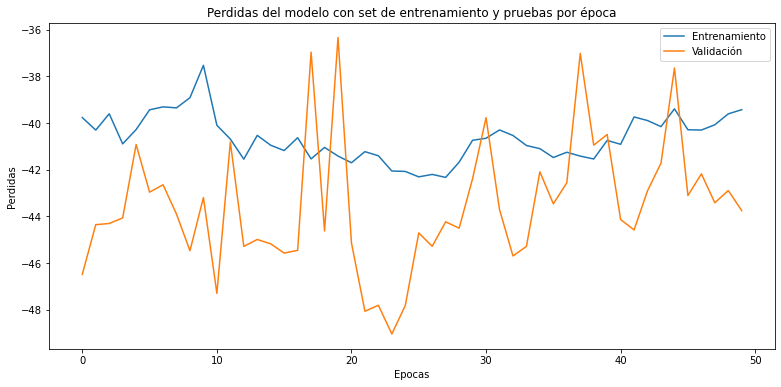

In [80]:
plt.figure(figsize = (13,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdidas del modelo con set de entrenamiento y pruebas por época')
plt.ylabel('Perdidas')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

In [81]:
history = model.fit(X_train1, y_train1, validation_data = (X_val1, y_val1), epochs = 15, batch_size =  300, verbose = 1)

Epoch 1/15
818/818 [==============================] - 5s 7ms/step - loss: -39.5943 - accuracy: 0.8082 - val_loss: -41.2002 - val_accuracy: 0.8230
Epoch 2/15
818/818 [==============================] - 5s 6ms/step - loss: -39.2179 - accuracy: 0.8074 - val_loss: -42.8264 - val_accuracy: 0.8286
Epoch 3/15
818/818 [==============================] - 5s 7ms/step - loss: -39.5065 - accuracy: 0.8007 - val_loss: -40.5206 - val_accuracy: 0.8117
Epoch 4/15
818/818 [==============================] - 5s 7ms/step - loss: -39.4086 - accuracy: 0.8069 - val_loss: -43.4423 - val_accuracy: 0.8132
Epoch 5/15
818/818 [==============================] - 5s 7ms/step - loss: -39.8409 - accuracy: 0.8116 - val_loss: -42.0355 - val_accuracy: 0.8025
Epoch 6/15
818/818 [==============================] - 6s 8ms/step - loss: -39.2940 - accuracy: 0.8076 - val_loss: -45.7876 - val_accuracy: 0.8421
Epoch 7/15
818/818 [==============================] - 6s 7ms/step - loss: -40.0614 - accuracy: 0.8048 - val_loss: -37.9327 -

In [82]:
#Evaluando el modelo
result = model.evaluate(X_test1, y_test1)
for i in range(len(model.metrics_names)):
    print(f'Metrics {model.metrics_names[i]} = {round(result[i],2)}')

4195/4195 [==============================] - 3s 812us/step - loss: -22.0641 - accuracy: 0.6187
Metrics loss = -22.06
Metrics accuracy = 0.62


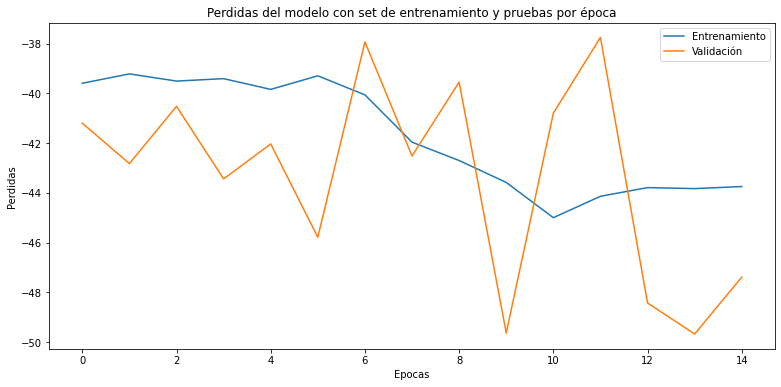

In [83]:
plt.figure(figsize = (13,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdidas del modelo con set de entrenamiento y pruebas por época')
plt.ylabel('Perdidas')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

In [ ]:
n_steps=9
x_lab1=[]
#Carga los datos originales
for i in range(dataset.shape[0]):
    x_lab1.append(i)
x_lab2=[]
for i in range(X_train1.shape[0]):
    x_lab2.append(i)
x_lab3=[]
#for i in range(X_test.shape[0]+19,trainN.shape[0]+1):
for i in range(trainN.shape[0],values.shape[0]-n_steps-n_steps_out):
    x_lab3.append(i)
plt.plot(x_lab1,polucion, alpha=1, label='Original series');
plt.plot(x_lab2,trainPredict1,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict1, alpha=0.6, label='test prediction');
plt.title("prediction for look_back= 9 including pollution RNN")
plt.legend();

## Matriz de confusión

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
 
expected = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
predicted = [1, 0, 0, 1, 0, 0, 1, 1, 1, 0]
results = confusion_matrix(expected, predicted)
print(results)

def build_fc_model(layers):
    fc_model = Sequential() #Crea un objeto vacio que contendra el modelo
    for i in range(len(layers)-1):
        #print(f'input_dim = {layers[i]}')
        #print(f'output_dim = {layers[i+1]}')
        
        #Para evitar problemas defina los valores de las neuronas por fuera de Dense
        output_dim = layers[i+1]
        input_dim = layers[i]
        fc_model.add(Dense(layers[i+1], input_dim = layers[i]))              
        fc_model.add(Dropout(0.25))
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu'))
            #model.add(Dense(4, activation="softmax", kernel_initializer=init))
        #else:
        #    fc_model.add( Activation('sigmoid'))
    fc_model.summary()
    
    return fc_model

fc_model_1 = build_fc_model([2, 512, 512, 1024, 1])

In [ ]:
adam = Adam(lr = 1e-5) #Optimizador con learnig rate de 1e-5
fc_model_1.compile(loss='mean_squared_error', optimizer=adam, metrics=['binary_accuracy']) 
#Guarda los pesos del entrenamiento en ciertos puntos para continuar el entrenamiento o guardar el modelo
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1_2.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1, batch_size=300, verbose=1, epochs=20, validation_split=0.33, callbacks=[checkpointer])


In [ ]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

### Validando el modelo

In [ ]:
scores = fc_model_1.evaluate(X_test1, y_test1)
print("\n%s: %.2f%%" % (fc_model_1.metrics_names[1], scores[1]*100))

## Creando una nueva arquitectura

### División de los datos usando sklearn
- Como entrada usaremos los datos main_1 y main_2 correspondientes a las columnas 0 y 1
- Como layer usaremos el refrigerador 
- Las proporciones seran de 80 y 20%

In [ ]:
variables = data_casa_1[['mains_1','mains_2']].values
objetivos = data_casa_1['refrigerator_5'].values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(variables, objetivos, test_size = 0.2,  random_state = 2020)
print(f'x_train {x_train.shape}, x_test {x_test.shape}, y_train {y_train.shape}, y_test {y_test.shape}')

Se creara un grupo de control o evaluación para el conjunto de datos. Este conjunto sera extraido del conjunto de datos de train definidos en la línea anterior.  
En estos casos se toma la división en proporción 90 y 10%

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1,  random_state = 2020)
print(f'x_train {x_train.shape}, x_val {x_val.shape}, y_train {y_train.shape}, y_val {y_val.shape}')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

Por convension se toman valores multiplos de 2.  
loss = 'binary_crossentropy'

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim = x_train.shape[1], activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'Adam', loss = 'mse', metrics=['accuracy'])

In [ ]:
#pip install pydot

In [ ]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png',show_shapes=True)

In [ ]:
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 5, batch_size =  300, verbose = 1)

- Nuevamente se observa que el accuracy y la función de perdida no tienen ningún cambio o mejora a pesar de agregar capas ocultas y aumentar el número de neuronas. 
- Intentaremos mejorar los resultados normalizando los datos. 

### Normalizando los datos
Primero se hacemos una inspección visual para determinar si la base de datos tiene rangos de valores demasiado grandes entre ellos. 

In [ ]:
data_casa_1.head(10)

In [ ]:
etiquetas = list(data_casa_1)
for i in range(len(etiquetas)):
    print(f'{etiquetas[i]} max =  {data_casa_1[etiquetas[i]].max()} {etiquetas[i]} min =  {data_casa_1[etiquetas[i]].min()}')

#print(f'mains_1 max =  {data_casa_1["mains_1"].max()} mains_1 min =  {data_casa_1["mains_1"].min()}')

- Los datos estan demasiado separados variando desde decimales a miles
- Como se mensiono probaremos si el modelo mejora al normalizar los datos, si bien las medidas maximas tomadas del refrigerador estan en el mismo orden de magnitud de las medidas de las líneas se probara como primer aproximación. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
scaler2 = StandardScaler()
ytrainRS = y_train.reshape(-1,1)
yvalRS = y_val.reshape(-1,1)
scaler2.fit(ytrainRS)
y_train_scaled = scaler2.transform(ytrainRS)
y_val_scaled = scaler2.transform(yvalRS)

In [ ]:
#Se va a normalisar el conjunto de datos total
from sklearn import preprocessing
df_n1 = data_casa_1
scaler = preprocessing.Normalizer(norm = 'l2', copy=True)
df_n1 = scaler.fit_transform(df_n1)

In [ ]:
variables = df_n1[:,:1]
objetivos = df_n1[:,2]

In [ ]:
from sklearn.model_selection import train_test_split
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(variables, objetivos, test_size = 0.2,  random_state = 2020)
print(f'x_train_norm {x_train_norm.shape}, x_test_norm {x_test_norm.shape}, y_train_norm {y_train_norm.shape}, y_test_norm {y_test_norm.shape}')

x_train_norm, x_val_norm, y_train_norm, y_val_norm = train_test_split(x_train_norm, y_train_norm, test_size = 0.1,  random_state = 2020)
print(f'x_train {x_train_norm.shape}, x_val {x_val_norm.shape}, y_train {y_train_norm.shape}, y_val {y_val_norm.shape}')

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim = x_train_norm.shape[1], activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'Adam', loss = 'mse', metrics=['accuracy'])
model.fit(x_train_norm, y_train_norm, validation_data = (x_val_norm, y_val_norm), epochs = 200, batch_size =  300, verbose = 1)

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim = x_train_norm.shape[1], activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'Adam', loss = 'mse', metrics=['accuracy'])
history = model.fit(x_train_norm, y_train_norm, validation_data = (x_val_norm, y_val_norm), epochs = 200, batch_size =  300, verbose = 0)

- En apariencia la arquitectura ha mejorado radicalmente su funcionamiento
- Debemos evaluar de manera grafica el proceso de entrenamiento

### Evaluando el desempeño del modelo
- Vamos a verificar que los resultados entre el set de entrenamiento y el de pruebas no difieran demasiado.
- Si difieren demasiado sera un indicativo que el modelo tiene problemas (sobre entrenamiento) para generalizar su respuesta a nuevos datos de entrada. 

In [ ]:
result = model.evaluate(x_test_norm, y_test_norm)
for i in range(len(model.metrics_names)):
    print(f'Metrics {model.metrics_names[i]} = {round(result[i],2)}')

Las perdidas obtenidas el valor obtenido fue de aproximadamente cero y el la presición del modelo fue cercana al 97%, similar al obtenido con el set de entrenamiento. 

#### Evaluación grafica

In [ ]:
plt.figure(figsize = (13,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdidas del modelo con set de entrenamiento y pruebas por época')
plt.ylabel('Perdidas')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

- Podemos observar como la función de perdida fue disminuyendo en cada epoca, tanto con los volores de entrenamiento como los de test. 
- Como el gap entre las dos líneas no es pronunciado, podemos inferir que nuestro modelo está funcionando de manera adecuada

In [ ]:
plt.figure(figsize=(13,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Pérdidas del modelo con set de entrenamiento y pruebas por época")
plt.ylabel('Accuracy')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

Nuevamente vemos comportamientos similares en los resultados obtenidos. 
Esta grafica muestra como el modelo ha mejorado su presición entre las diferentes epocas.  
El proximo paso sera probar este modelo con los datos provenientes de otras casas

## Ajuste de redes neuronales: overfitting y regularización

**Overfitting:** El sobre entrenamiento o sobre ajuste hace referencia a que la curva se ajusta de tal manera que cada punto del data set es cruzado por la función modelo
- Este fenomeno ocurre cuando entrenamos el modelo con información no apropiada o si exageramos la cantidad de epocas.  
- Esto ocasiona que el modelo memorice los datos, lo cual provoca que el modelo no sepa como interpretar datos que no ha visto en la etapa de aprendizaje.
- La grafica muestra la complejidad en el eje x y el error en el eje y. Se muestra como el error disminuye a medida que aumentamos la complejidad del entrenamiento. Pero llega un punto donde la prueba del modelo con los datos de test, deja de disminuir el error e inicia a aumentarlo. Este es un caso de sobre entrenamiento.
- Una opción para evitar este fallo es detener el proceso de entrenamiento cuando detectamos que el gap entre el set de entrenamiento y prueba son demasiado pronunciados o amplios. 
- Matematicamente cuando existe una alta varianza y un bajo baias es un indicador de overfitting.
- El estremo contrario es un indicador de sub entrenamiento. 

**Regularización:** La regularización es un método que nos ayuda a evitar el overfitting. Lo hace penalizando o minimizando la complejidad de la red neuronal. Esta penalización consiste en identificar la variables que no aportan o aportan poco a la identificación de la variable obetivo. Existen diferentes métodos de regularización:

- Regularización Lasso ó L1: Penaliza la suma de los valores absolutos de los pesos. Genera un modelo mas simple e interpretable. Es robusto a los outliers. 

- Regularización Ridge ó L2: Penaliza la suma de cuadrados de los valores de los pesos. El parametro lambda suele ser pequeño. Útil para aprender patrones complejos de los datos. No es robustoa outliers. Permite encontrar correlaciones entre datos de multiples variables. Por esto da valores altos a los pesos. 

- Regularización ElasticNet: Combina ambos beneficios de regularización Lx: L1: eliminar pesos no significativos L2: eliminar pesos correlacionados. Es muy util cuando tenemos multiples variables que se correlacionan entre si y otros que no son muy utiles entre sí. Requiere de dos parametros lambda correspondientes a las dos regularizaciones que lo conforman.

- Regulación dropout: Consiste en apagar de manera aleatoria un porcentaje de neuronas en cada capa. Esto ayuda a aumentar el tiempo de entrenamiento, al disminuir el número de neuronas en el modelo. Pero su aporte más importante, consiste en que las neuronas subsiguientes no dependeran absolutamente de los resultados de las neuronas que lo preceden. Disminuyendo el overfitting. En Keras se instancia despues de crear una capa indicando en sus parametros el % de neuronas a apagar. 

- BatchNorm: Este se considera una inovación clave en el deep learning moderno (2016). Similar a la normalización de los inputs, pero en capas intermedias. Consiste en tomar un batch de datos calcular su media y varianza, actualizar los datos restandolos por su media y dividiendo por su varianza a esto sumarle la constante epsilon, para luego aplicarle una transformación. Más información en este link:
https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

- Data Augmentation: Esta técnica es simple pero elgante y se aplica bastante en imagenes, consiste en rotar la imagen o hacerle un zoom e incluir esta matriz en el algoritmo, ya sea el de una red generativa o convolucional. Es la misma imagen pero su matriz de datos no es la misma.

In [ ]:
'''
#Ejemplo de regularización usando Keras

from keras import regularizers, Sequential
model = Sequential()
#Usando una regularización L1
model.add(Dense(24, input_dim = Numero_Variables,
                kernel_regularizaers = regularizaers.l1(0.01) #El parametro es el valor de lambda 
))

#Usando una regularización L2
model.add(Dense(24, input_dim = Numero_Variables,
                kernel_regularizaers = regularizaers.l2(0.01) #El parametro es el valor de lambda 
))

#Usando una regularización elastic net lx
model.add(Dense(24, input_dim = Numero_Variables,
                kernel_regularizaers = regularizaers.l1_l2(l1=0.01, l2 = 0.01) #El parametro es el valor de lambda 
))

#Usando regularización dropout, requiere el porcentaje de neuronas a apagar
model.add(Dropout(0.2))
'''

# Ajuste de redes neuronales: Hiper parámetros

Los parametros nos ayudan a ajustar los pesos sinapticos entre las neuronas. Es decir los pesos sinapticos que hacen la multiplicación entre las entradas y las funciones de activación para obtener la salida entre las capas.  
Adicionalmente existen los hiperparametros, que se refieren a las caracteristicas de configuración para ajustar el modelo de red neuronal, no existe un metodo que indique cuales son los valores adecuados para encontrar estos datos de ajuste. Sin embargo, si hay una serie de pasos logicos que ayudan a encontrar aproximaciones con buenos resultados. 

### Numero de capas y neuronas por capa:

**Numero de capas:** Al aumentar el numero de capas se aumenta el tiempo de entrenamiento y la complejidad del modelo. Pero a su vez, el modelo es capaz de aprender comportamientos muy complejos. La recomendación es iniciar con una pequeña arquitectura e ir aumentando poco a poco hasta encontrar una cantidad adecuada de capas. 

**Número de neuronas:** Este valor acompaña directamente el número de capas del modelo. Por convensión se inicia la primera capa como:  
Número de neuronas = Potencia de dos mas cercana a 2 * (número de neuronas).  

Por ejemplo: Variables = 30 entradas -> 30 * 2 = 60, la potencia mas cercana a 60 es 2^6 = 64  

Es aconsejable iniciar la primera capa con 64 neuronas. Las siguientes capas, generalmente tienen menos neuronas respecto a la primera, esta disminución debe hacerse tambien en potencias de dos. Por ejemplo 2^5 = 32 neuronas-

### Épocas e inicializadores 

**Epocas:** A medida que se va entrenando el modelo (mas epocas), la función de error va disminuyendo. Pero llega un punto donde la función de error para el set de entrenamiento sigue disminuyendo pero para el set de prueba aumenta. En este punto las dos graficas divergen y podemos usar este punto como metodo de regularización. A este punto se le denomina early termination y servira para ajustar este modelo hasta esta cantidad de epocas. 

**Inicializadores:** La inicialización glorot es ampliamente usada y generalmente acertada para inicializar los pesos de nuestra red neuronal. 

**Taza de aprendizaje o learning rate:** El optimizador de adam tiene un valor por defecto para inicializar

**Batch o lote de datos:** Sirve para entregar un lote de datos por partes, este tamaño se recomienda pasarlo en función de una potencia de dos. Si aumentamos el tamaño de batch el entrenamiento sera mas preciso pero más lento de entrenar. Si el batch es pequeño, el modelo entrenara mas rapido pero pierde presición.

## Funciones de activación y perdida:

Elegir una de ellas esta ligado a si tenemos una regresión o una clasificación. La siguiente tabla resume las recomendaciones para elegir la función de perdida y la función de activación de la ultima capa según el tipo de salida que tenemos como resultado de nuestro modelo. Para las capas ocultas es recomendable usar relu y comunmente MSE 

| Tipo de problema| Tipo de salida                         | Función de activación final | Función de perdidas    |
| :-------------: | :------------------------------------: | :-------------------------: | :--------------------: |
| Regresión       | Valor numerico                         | Linear                      | Mean Square Error      |
| Clasificación   | Salida Binaria                         | Sigmoid                     | Binary cross entropy   |
| Clasificación   | Unica etiqueta, multiples clases       | Softmax                     | Cross entropy          |
| Clasificación   | Multiples etiquetas, multiples clases  | Sigmoid                     | Binary cross entropy   |

## Librerias de ajuste y optimización de hiperparametros en Keras

- Hiperopt -> Libreria popular de Python enfocada en optimizar todo tipo de espacios de busqueda, incluyendo espacios reales como las tasa de aprendizaje, o valores discretos como el número de capas. 
- Hyperast, kopt o talos -> Librerias de optimización de modelos implementados en keras
- Scikit optimize (Skopt) -> Hace una busqueda de hiperparametros en modalidad de grilla. Evalundo diferentes combinacioenes hasta optener un punto optimo. 

En cuanto a keras existen algo conocido como callbacks que son procesos que se aplican dentro del entrenamiento y mejoran estos hiperparametros, en el orden del video que conozca existen:

**EarlyStopping**
Este detiene el entrenamiento al no ver mejora en una metrica como la perdidad, error, loss, val_loss, entre otras, cuenta con un parametro paciencia que permite ajustar a las epocas de no ver mejoria en el entrenamiento parara.

**ModelCheckpoint**
Este callback guarda los pesos y estructura del modelo entrenado por cada epoca, tambien se puede configurar para que guarde solo si el modelo ha mejorado en la epoca actual.

**ReduceLROnPlateau**
Tiene la funcion de monitorear una metrica de mejora configurada por el usuario y cuando no vea mejora reduce la taza de aprendizaje(Learning Rate) lo que le permite frenar el paso cada vez mas y encontrar el minimo local o global.

**Tensorboard**
Es un dashboard con toda la informacion y metricas pertinentes configurada en uno o varios modelos, es un tablero superdinamico que permite comparar modelos y configuraciones.

# La normalización ha fracasado investigar como se normaliza de manera correcta una señal

In [ ]:
from keras.models import Sequential from keras.layers import Dense, Activation model = Sequential() model.add(Dense(102, input_dim=102, kernel_initializer='normal',activation='relu')) model.add(Dense(30, kernel_initializer='normal',activation='relu')) model.add(Dense(10, kernel_initializer='normal',activation='relu')) model.add(Dense(3, kernel_initializer='normal')) model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_absolute_percentage_error'])